# Le mécanisme d'attention


- Hey chatGPT, avec quoi t'es fait ?
- Je suis un modèle "transformer" basé sur le mécanisme d'attention. Si tu veux en savoir plus, écoute bien le cours qui va suivre. J'aurai pu tout t'expliquer moi-même, mais je ne vais quand même pas prendre le boulot de M. Vigon. 😉

## Pourquoi l'attention

### Embeding préliminaire

Les  applications que nous allons présenter maintenant concernent le traitement du langage naturel. Les modèles de deeplearning travaillent à partir de vecteurs. Il nous faut donc une technique pour transformer des mots en vecteur.

Une bonne technique pour cela est  *l'embeding* (plongement). Chaque mot du dictionnaire est associé à un vecteur de grande dimension:

        a      → [3.5 2.7 8.8 0.5 5.7 9.1 2.6 4.5 2.1 0.8 7.3]
        about  → [2.1 2.1 1.3 3.5 4.7 2.1 3.2 3.1 1.8 9.4 3.8]
        absurd → [3.2 5.2 6.1 9.1 3.1 2.7 3.0 1.6 3.4 6.6 2.7]
        ...

Ces vecteurs sont des trainable-variables. Ils vont être modifié par l'optimiseur pour atteindre son but (minimisation d'une loss). Ce que l'on constate, c'est que les relations sémentiques entre mot vont  se transformer en des relations vectorielles comme l'illustre la figure ci-dessous.




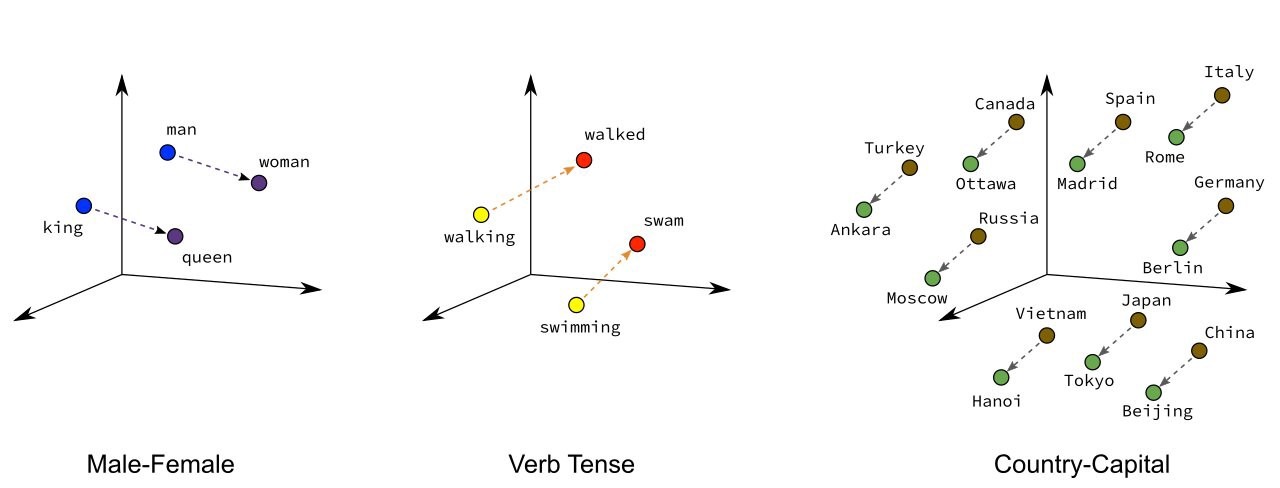

Les relations sémentiques entre mots sont nombreuses et diverses, mais les directions vectorielles, en grande dimension, sont aussi très nombreuses ; le dessin ci-dessus, en dimension 3 (seulement), n'est pas très réaliste.

### Un prédicteur de mot

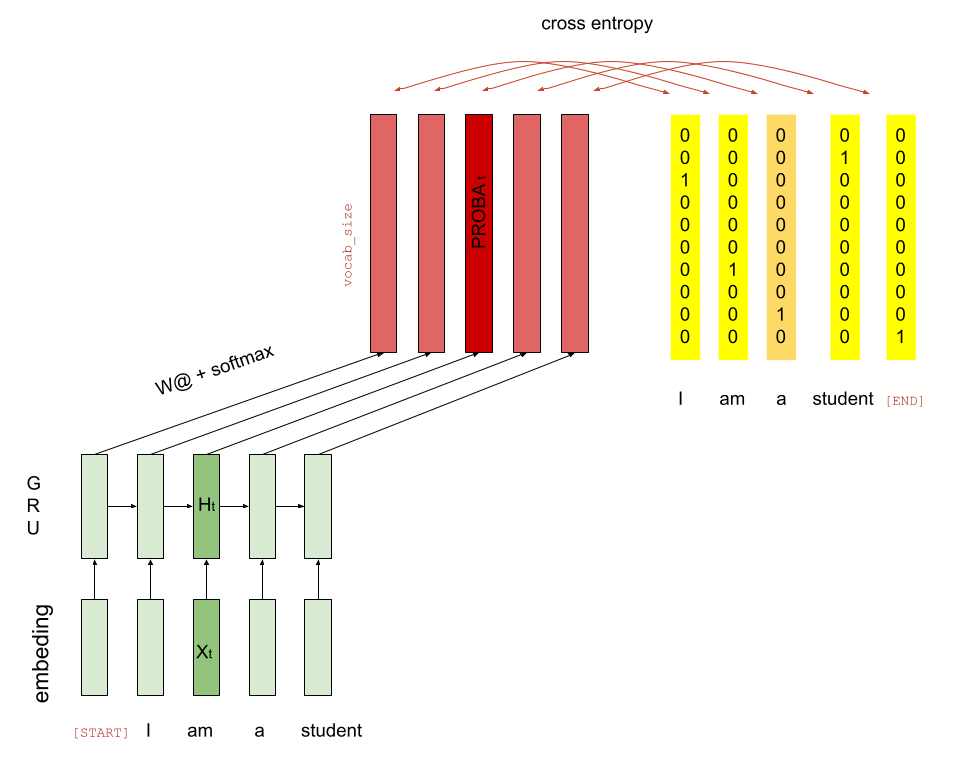

***Le but:***

* On a un jeu de données de phrase (ici en anglais).
* On veut créer un chatbot.
* Il suffit de créer un modèle qui prédise le mot suivant. On pourra ainsi de proche en proche créer des phrases complètes (en partant d'une question par exemple).
* Autre façon : il suffit de créer un modèle capable de décaler une phrase, de manière non-anticipative.


***A vous:*** Pourquoi est-ce plus interessant de prédire les phrases décalées plutôt que juste le mot suivant ?


***La technique:***

* Les mots sont transformés en vecteurs $(X_t)$ par embeding.

* La suite $(X_t)$ est transformée en une autre séquence $(H_t)$ par un modèle GRU (ou LSTM) qui a un pouvoir prédictif avec une longue mémoire.

* Avec une multiplication matricielle par un noyau $W$ (indépendant de $t$), et un softmax, chaque vecteur $H_t$ est transformé en un vecteur de probabilité, de taille `vocab_size` (le nombre de mots possibles)

* La proba ainsi obtenue est comparée avec la dirac en le mot qu'on voulait obtenir. L'entrainement consistant à faire se rapprocher ces deux probabilités.

***A vous:*** Voici une propriété des RNN en général (et des GRU en particulier): le vecteur produit $H_t$ ne dépend que des $H_k$ avec $k<t$ et des $X_k$ avec $k\leq t$. Pourquoi est-ce très important ?

### Variante

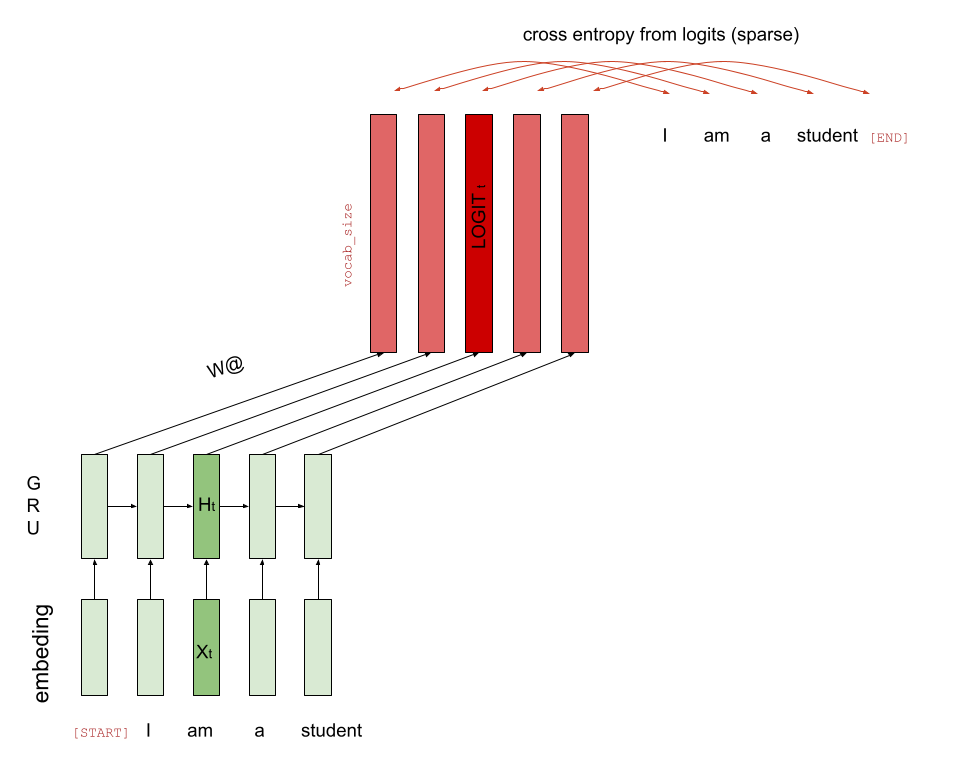

***A vous:*** Qu'est-ce qu'on a changé ?

* Rappelons que le cross-entropy sparse entre $y$ (l'indice d'une classe) et $p$ un vecteur de proba c'est:
$$
 -\log p (y) = \sum_u -\delta_y(u) \log(p(u))
$$
* Et que sa version "from logits" entre $y$ (l'indice d'une classe) et $\ell$ un vecteur de logits c'est:
$$
 -\log \mathtt{SM}[ \ell (y)]
$$
où $\mathtt{SM}$ est la fonction softmax.


### Un traducteur

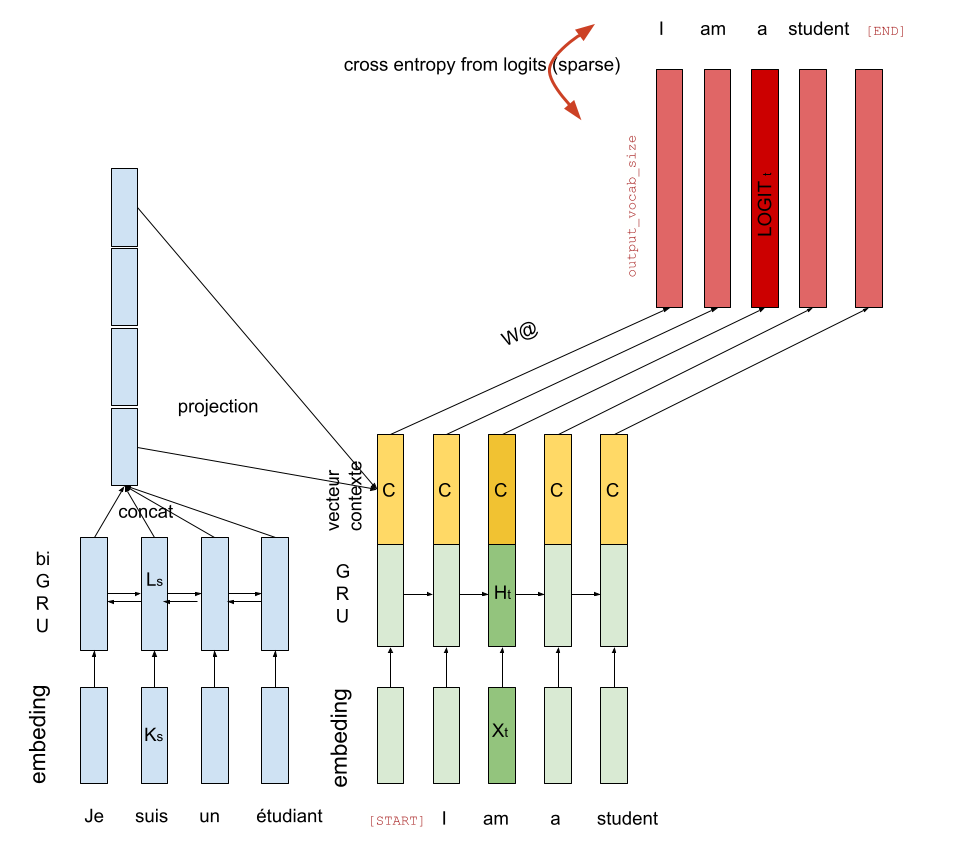

Un traducteur, c'est un prédicteur de mot aiguillé par un "contexte"  fournit par une phrase dans la langue source (ici le français). Il est composé de deux parties:


***L'encodeur:***

* Il encode la phrase de la langue source par embeding puis par un modèle RNN (ici un GRU bidirectionnel, mais peu importe).

* Il concatène les vecteurs $L_s$. Effectue une multiplication matricielle pour réduire la dimension. Cela donne un vecteur de contexte $C$.


***Le décodeur:***

* Il encode la phrase de la langue cible par embeding puis par une modèle RNN (ici un GRU directionnel). Cela donne une suite $(H_t)$

* Il concatène le vecteur contexte $C$ avec $H_t$. Multiplie le tout par une matrice-entrainable $W$, pour créer le Logits de la t-ième prédiction (si on ajoute un softmax, on obtient le vecteur de probabilité de la t-ième prédiction).


***A vous:*** Pourquoi cela ne va pas très bien marcher ?  Aide: Qu'est-ce qui manque à notre vecteur de contexte $C$ ?

Il faut donc introduire un mécanisme corrigeant ce défaut.

## Le mécanisme de l'attention

Le mécanisme de l'attention permet de transformer une suite de vecteur $Q$ (Query) en une autre suite de même longueur $Q'$, sous l'influence d'une paire de suite $K,V$ (Key,Value).

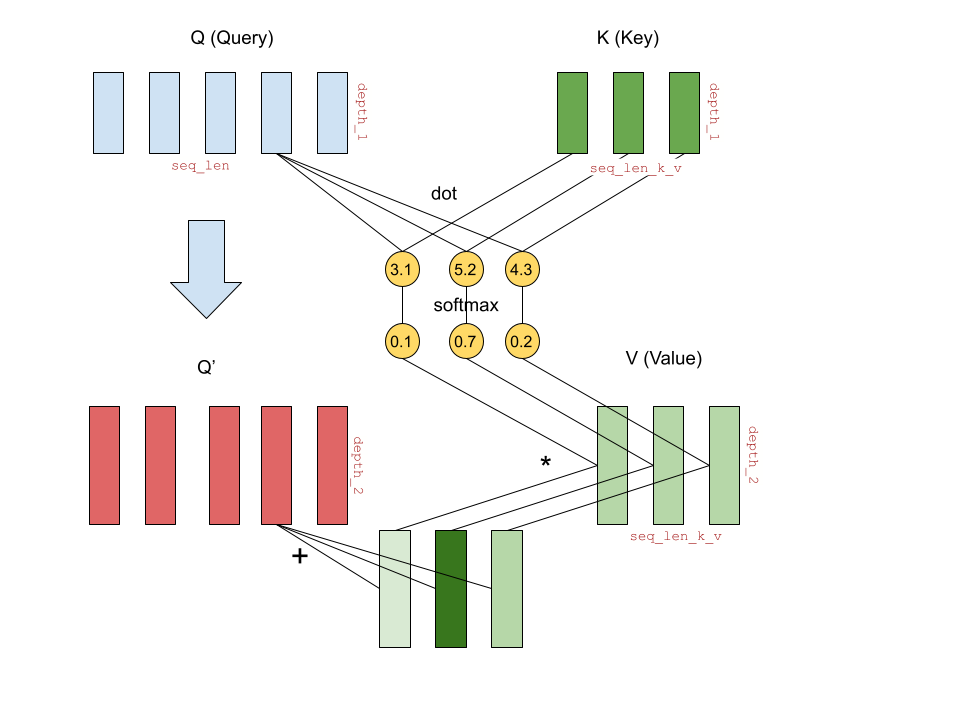

### Sans normalisation


* On dispose d'une suite de vecteurs $(Q_t)$ appelée Query, qui encode une suite de données  (ex: une série temporelle de donnée météo ou l'encodage d'une phrase).

* On voudrait la faire évoluter en suite suite $(Q'_t)$ de même longueur, sous l'influence de deux suites de vecteurs  $(K_s)$, les Keys, et $(V_s)$, les Values.

* Fixons $t$. Pour calculer $Q'_{t}$ on calcule d'abord les poids d'attention $\alpha_{ts}$  par:
$$
\alpha_{ts} = \mathtt{softmax}(Q_{t}\cdot K_{s})={\exp(Q_{t}\cdot K_{s})\over \sum_u\exp(Q_{t}\cdot K_{u})}
$$
Le point médiant $\cdot$ étant le produit scalaire. Ces poids d'attention satisfont:
$$
\sum_s \alpha_{ts}=1
$$

Ensuite on fait la somme des $V_{s}$ pondérée par les $\alpha_{ts}$:
$$
Q'_{t} = \sum_s \alpha_{ts} V_{s}
$$

***A vous:*** Complétez les trois petits points dans la phrase ci-dessous:

$Q'_t$ est essentiellement influencé par les $V_s$ tels que les $K_s$ correspondants sont ... avec $Q_t$.

### Matriciellement

* Notons $Q$ et $Q'$ les matrices dont les lignes sont les $Q_t$ et $Q'_t$

* Notons $K$ et $V$ les matrices dont les lignes sont les $K_s$ et $V_s$

Attention, avec cette disposition, visuellement, il faut transposer le schéma du dessus.

La matrice $\alpha$ vaut
$$
\alpha=\text{softmax}\left({QK^T}\right)
$$
et donc la matrice $Q'$ vaut:
$$
Q' = \text{softmax}\left({QK^T}\right) V
$$
où  le softmax est calculé ligne à ligne, selon les colonnes (informatiquement `axis=1`).


***A vous:*** Identifiez les contraintes de shapes qu'il y a sur les trois matrices $Q,K,V$. Et quelle est la shape de la matrice $Q'$.

### Avec normalisation



On a fait une simplification précédemment: En vérité, avant d'être passé au softmax, les produits scalaires sont divisés par $\sqrt{d_1}$ où $d_1$=`depth_1` est la dimension des vecteurs que l'on passe au produit scalaire.  La formule complète est donc:
$$
Q' = \text{softmax}\left(\frac{QK^T}{\sqrt{d_1}}\right) V
$$





Pourquoi cette mise à l'échelle par $\sqrt{d_1}$ ?  Pour les grandes dimensions de vecteurs, le produit scalaire prend potentiellement de grandes valeurs, et du coup, le softmax prend des valeurs prochent de 1 ou 0. On aimerait quelque chose de plus "soft". On divise donc par l'ordre de grandeur du produit scalaire qui vaut $\sqrt{d_1}$, en effet:

***Lemme:*** Considéreons les vecteurs $Q_t$ et $K_s$. Supposons que leurs coordonnées soit des v.a indépendante d'espérance $0$ et d'écart-type $1$.  Alors le produit scalaire $Q_t \cdot K_s$ a une moyenne de 0 et un écart-type de $\sqrt{d_1}$.

*Démo:*
$$
E[\sum^{d_1-1}_{i=0} Q_{t,i} K_{s,i}  ] =0
$$
Donc la variance, c'est l'espérance du carré:
$$
E[ \Big(\sum^{d_1-1}_{i=0} Q_{t,i} K_{s,i}  \Big)^2] = d_1
$$
***A vous:*** ajoutez quelques étapes de calcul.



###  Bahdanau's additive attention

D'autres formules d'attention ont été inventée. Par exemple celle de Bahdanau. On commence par calculer:

$$
score( Q_t,K_s) = \tanh(W \cdot Q_t+W'\cdot K_s)
$$
où $W$ et $W'$ sont des vecteurs entrainables de même taille que $Q_t$ et $K_s$.

Ensuite vient le softmax:
$$
\alpha_{ts} = \frac{\exp\big( \text{score}(Q_t,K_s)\big)}{\sum_{u} \exp\big(\text{score}(Q_t,K_{u})\big) }
$$
Puis comme précédemment:
$$
Q'_t = \sum_s \alpha_{ts} V_s
$$

 L'idée est la même: quand les vecteurs $Q_t$ et $K_s$ sont alignés d'une "certaines manières", leur poids d'attention est grand.  Cette "certaine manière" est paramétrée par des variables entrainables (alors qu'il n'y en a aucune dans l'attention de base).

## Quelques applications

### Traducteur amélioré

Pour alléger le shéma ci-dessous, certains vecteurs n'ont pas été répété. On s'est focalisé le la t-ième étape.

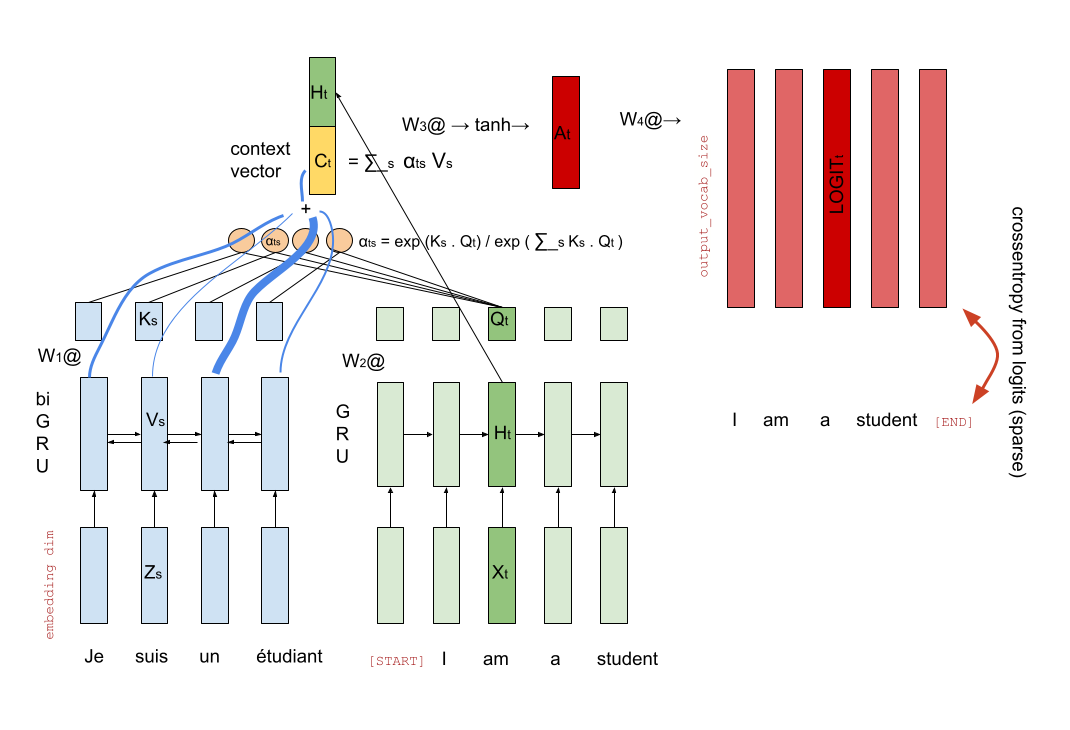

* La phrase source (en français) est encodée avec un embeding + bi-GRU. Cela donne $(V_s)$. Ce seront les "values" de l'attention.

* La phrase target (en anglais) est encodée avec un embeding + GRU. Cela donne $(H_t)$.

* On créer les "Keys":
$$
K_s= W_1  V_s
$$

* On crée les "Queries":
$$
Q_t = W_2  H_t
$$

* Le vecteur de contexte $C_t$ est obtenu par la formule d'attention. Il est concaténé avec $H_t$, puis transformé en
$$
A_t = \tanh (W_3  [C_t;H_t])
$$

* Une dernière multiplication matricielle donne le vecteur de logits de la t-ième prédiction.



***Qu'est-ce qui change par rapport au traducteur naïf ?***

Au fil de  l'entrainement, le modèle va être capable de produire des vecteurs de contextes $C_t$ qui seront bien adapté au mot courant qu'on essaye de prédire.

Regardons le dessin ci-dessus: on essaye de prédire le mot "a" qui suit "am". Le coefficient $\alpha_{ts}$ qui aura la plus grande valeur sera naturellement celui correspondant au mot français "un".


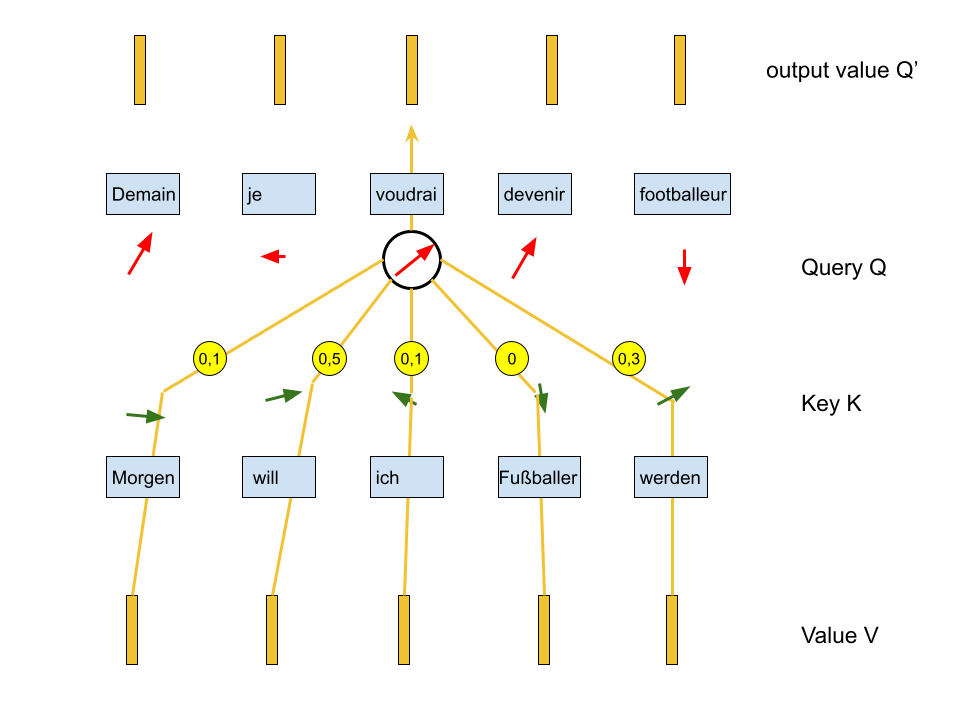

Autre représentation, pour une traduction de l'allemand vers le français: Pour prédire "voudrai", les mots importants du contexte sont "will" (verbe vouloir), mais aussi "werden" (marque du furtur) et dans une moindre mesure "ich"  (première personne du singulier) et "Morgen" (autre marque du furtur).


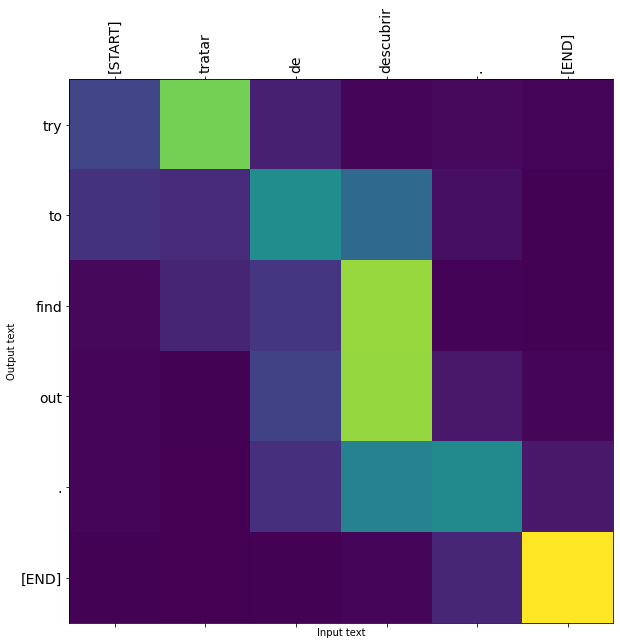

Ceci n'est plus un shéma, mais la sortie d'un programme qu'on verra dans le prochain TP. L'attention a bien compris que la traduction de "descubrir" est "find out" (en 2 mots).

### Transformer


Avec ce traducteur, nous venons de voir l'utilisation "initiale" du mécanisme d'attention. Qui lui a donné son nom.

Mais on peut aussi  garder en tête que l'attention est un mécanisme qui permet de passer d'une suite $Q$ à une suite $Q'$, sous l'influence de $K,V$.

Et si on n'a pas d'influenceur, on peut simplement prendre $Q=K=V$. On parle alors d'auto-attention: un mécanisme pour transformer une suite $Q$ en une suite $Q'$.

Notons que la dépendance entre $Q'$ et $Q$ est "totale": pour calculer un élément $Q'_t$ on utilise entièrement tous les $(Q_s)$.  

Reprenons le traducteur précédent.   En remplaçant les layers GRU par des layers d'auto-attention, on obtient le fameux transformers.


<table>
<tr>
  <th>The <a href=https://www.tensorflow.org/text/tutorials/nmt_with_attention>RNN+Attention model</a></th>
  <th>A 1-layer transformer</th>
</tr>
<tr>
  <td>
   <img width=411 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-words.png"/>
  </td>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

***À gauche:*** un autre dessin pour le traducteur déjà rencontré. La matrice carrée bleue représente la matrice des coefficients $(\alpha_{st})$. Notons qu'elle n'est pas forcément carrée (la phrase de la langue source n'a pas forcément la même taile que la phrase de la langue cible).

***À droite:*** Le modèle transformer: le bi-GRU de l'encodeur a été remplacé par un layer d'auto-atention. Le GRU du décodeur a été remplacé par un l'ayer d'auto-attention spécial: on lui a ajouté un masque triangulaire sur les  $(\alpha_{st})$ pour obtenir la propriété de non-anticipation (on détaillera plus tard).


### Et chatGPT

C'est un prédicteur de mot basé sur le mécanisme d'attention. On verra dans un autre TP que c'est un peu plus compliqué que le dessin ci-dessous.

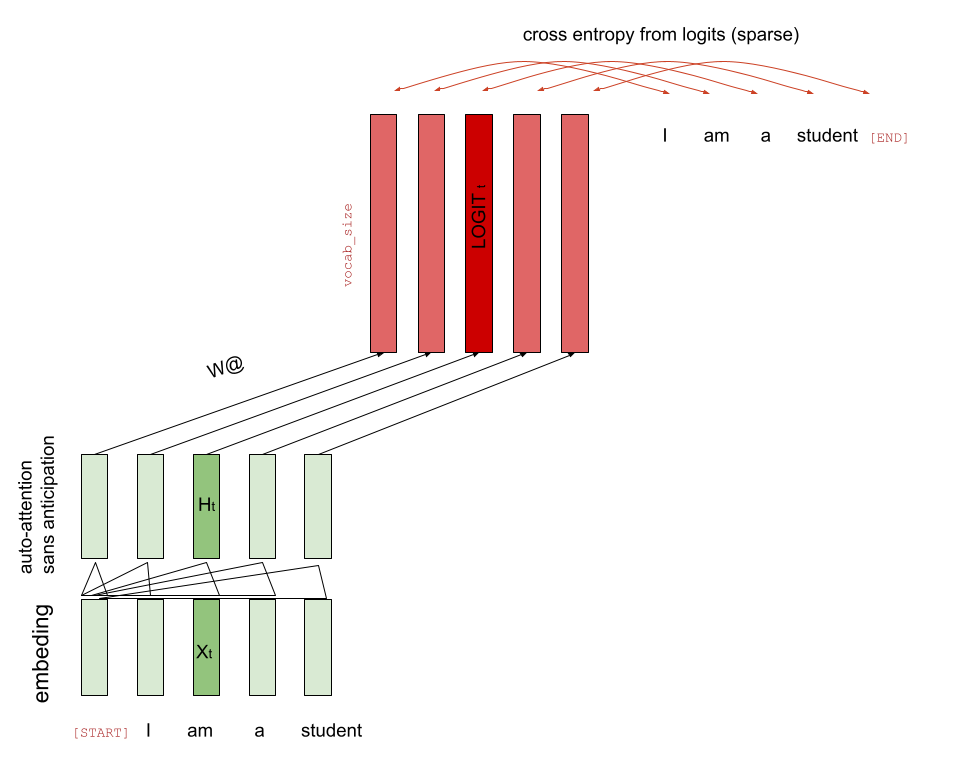

Ci-dessous un schéma complet du modèle GPT, que l'on expliquera dans un prochain TP. Si vous êtes impatient, [ici il y a des explications](https://dugas.ch/artificial_curiosity/GPT_architecture.html)

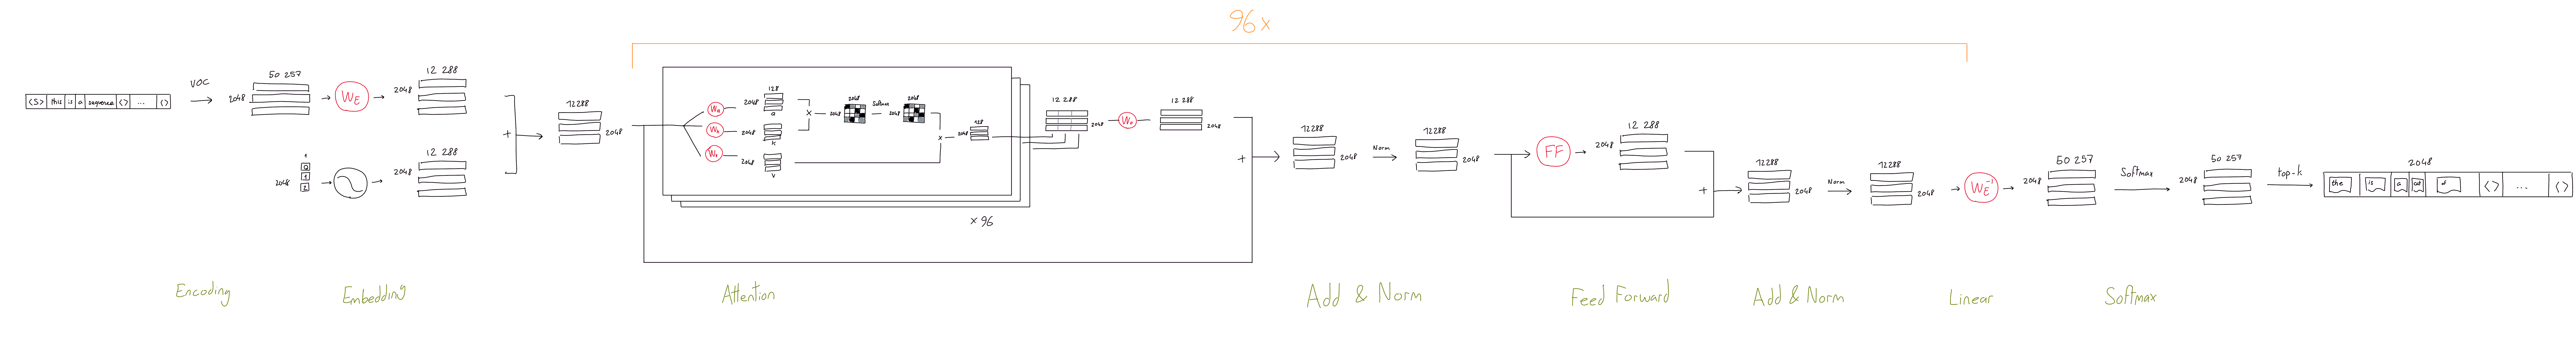

## Implémentation

### Setup

In [ ]:
%reset -f

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

tf.random.set_seed(5)


### Une fonction simple à coder

In [ ]:
def attention(Q,V,K):
    """
    Args:
        Q: query shape = (..., T,  depth_1)
        V: value shape = (..., S,  depth_2)
        K: key shape   = (..., S,  depth_1)

    renvoie:
        sofmax(QK.T)V
    avec au passage la normalisation par sqrt(depth_1)
    """
    #QKt = Q@tf.transpose(K)
    QKt = tf.matmul(Q, K, transpose_b=True)   # (..., T, S)
    depth_1 = tf.cast(K.shape[-1], tf.float32)
    QKt/=tf.sqrt(depth_1)


    attention_weights = tf.nn.softmax(QKt, axis=-1) # (..., T, S)
    output = tf.matmul(attention_weights, V) #(...,T, depth_2)
    return output, attention_weights

Un outil pour illustrer. On va toujours se placer dans le cas où $V=K$.

In [ ]:
def plot_attention_simple(Q, VK, output, attention):

    fig,(ax,ax2) = plt.subplots(1,2,figsize=(10,4))

    ax.matshow(attention)
    ax.set_xticks(range(len(VK)))
    ax.set_yticks(range(len(Q)))

    labels = [str(elem) for elem in VK]
    ax.set_xticklabels(labels, rotation=90)

    labels = [str(elem) for elem in Q]
    ax.set_yticklabels(labels)
    ax.set_xlabel("Value=Key")
    ax.set_ylabel("Query")

    res=ax2.matshow(output)
    ax2.axis("off")

    fig.colorbar(res)
    fig.tight_layout()

In [ ]:
Q=np.random.randint(0,3,[7,2]).astype(np.float32)
K=V=np.random.randint(0,3,[5,2]).astype(np.float32)

output, attention_weights=attention(Q,V,K)
output.shape, attention_weights.shape

In [ ]:
plot_attention_simple(Q,V,output,attention_weights)

* À gauche: la matrice des poids d'attention $(\alpha_{ts})$.

* À droite: la matrice $Q'$.

De grands coefficients $(\alpha_{ts})$ apparaissent quand les vecteurs de la Query et ceux de la Key-Value sont presques alignés. Regardons par exemple la dernière ligne dans le dessin ci-dessous: Les deux grands coefficients correspondent au produit scalaire `[1 2] . [2 1]`. Ainsi la dernière ligne de la sortie à droite vaut approximativement `0.5 * [2 1] +   0.5 * [2 1]`



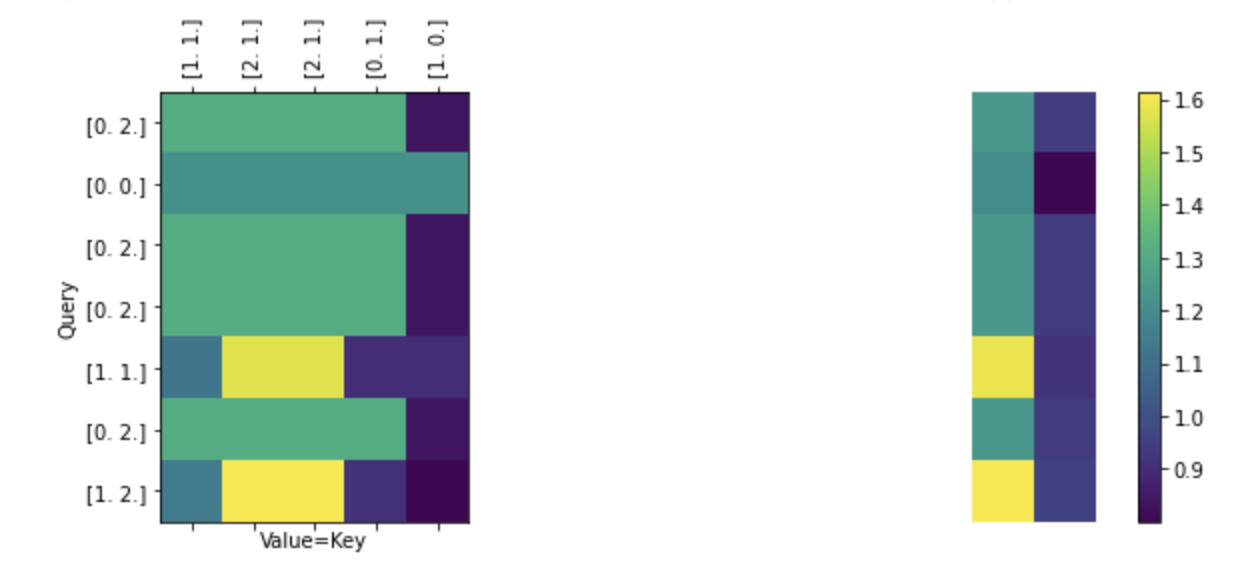

***À vous:*** Interpréter la seconde ligne.

### Pour des gros tenseurs

La fonction `attention` fonctionne aussi avec des tenseurs $Q,V,K$ de dimensions $\geq 2$. Les premières dimensions ne sont pas touchées (ce sont des dimensions de batch).

Cette souplesse vient de la fonction `tf.matmul` qui effectue la multiplication matricielle sur les indices les plus à droite. Par exemple, si les tenseurs sont de dimensions 4:
                        
$$
\mathtt{C = tf.matmul(A,B) } \Leftrightarrow
$$
$$
C_{abik} = \sum_j A_{abij} B_{abjk}
$$
C'est tout à fait idem pour le layer `Dense` de keras puisque

    Dense(X) = tf.matmul(X,W) + B

ou `W, B` sont les kernel et bias stocké dans l'objet `Dense` sous-jacent.




In [ ]:
#testons la fonction 'attention(q,v,k)' sur des tenseurs de dimension 4
batch_size_1=1
batch_size_2=2

T=5
S=3

depth_1=10
depth_2=11

Q=tf.random.uniform([batch_size_1, batch_size_2, T, depth_1])
K=tf.random.uniform([batch_size_1, batch_size_2, S, depth_1])
V=tf.random.uniform([batch_size_1, batch_size_2, S, depth_2])

Q_prime,_=attention(Q,V,K)

assert Q_prime.shape == (batch_size_1, batch_size_2, T,depth_2)

## Multi-head attention






### Principe

L'attention à têtes multiples reçoit trois entrées :  $Q,V,K$ qui ont maintenant toutes le même nombre de colones: `depth_1=depth_2=:depth`.

* elles passent par des couches linéaires (denses)
* Leurs vecteurs sont découpées  `num_heads` parties (=têtes).
* La fonction `attention`  est appliquée à chaque tête.  
* Les sorties des têtes sont ensuite concaténées  et passées par une couche finale `Dense`.

Cette multiattention permet au modèle d'analyser diverses relations entre les suites de vecteurs.




Mathématiquement:

Entrée :  $Q,V,K$. Ces 3 tenseurs ont pour shape `(batch_size, seq_len, depth)` avec `depth` qui se factorise en `num_head * head_size`

Entrée modifiée linéairement: On considère des matrices de paramètres $W^V,W^K,W^Q$ de shape `(depth,depth)` et l'on fait:
$$
\begin{align}
V &\leftarrow V W^V \\
K &\leftarrow KW^K \\
Q &\leftarrow QW^Q
\end{align}
$$

Les shapes n'ont pas changées.

On découpe les 3 tenseurs en `num_head` parties le long de leur dernier indice (celui de `depth`).

Techniquement avec un simple reshape.

Mathématiquement, on  ajoute un indice:
$$
\begin{align}
V \to (V_h)_{h=1,...,\mathtt{num\_head}}\\
K \to (K_h)_{h=1,...,\mathtt{num\_head}}\\
Q \to (Q_h)_{h=1,...,\mathtt{num\_head}}
\end{align}
$$

On applique l'attention à chacun des bouts:
$$
Q'_h = \text{softmax}(\frac {Q_h K_h^T} {\sqrt{d}}  )V_h
$$
où $d=$ `head_size`, puis on recolle les bouts:
$$
Q' = \text{concat}_h Q'_h
$$
On applique une dernière transformation linéaire:
$$
Q' \leftarrow Q' W
$$


***Remarque:*** Dans l'article sur le Linformer (variante du transformer), la première multiplication matricielle est appliquée après la division en plusieurs tête :
$$
Q \to (Q_h)_{h=1,...,\mathtt{num\_head}}
$$
Puis pour chaque $h$:
\begin{align}
Q_h &\leftarrow Q_h W^{Q_h}\\
V_h &\leftarrow V_h W^{V_h}\\
K_h &\leftarrow K_h W^{K_h}\\
\end{align}


***À vous:*** Quelle technique requiert le moins de paramètre. Votez:
* 1:  découpage en têtes puis multiplication matricielle
* 2:  multiplication matricielle puis découpage en têtes

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">



### Code

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, depth, num_heads):
        super().__init__()

        self.num_heads = num_heads
        self.depth = depth

        assert depth % self.num_heads == 0

        self.head_size = depth // self.num_heads

        self.wv = tf.keras.layers.Dense(depth)
        self.wk = tf.keras.layers.Dense(depth)
        self.wq = tf.keras.layers.Dense(depth)

        self.dense = tf.keras.layers.Dense(depth)


    def split_heads(self, x):
        """Split the last dimension into (num_heads, head_size).
        Transpose the result such that the shape is (batch_size, num_heads, T, head_size)
        """
        batch_size,T,_=x.shape
        x = tf.reshape(x, (batch_size, T, self.num_heads, self.head_size))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q,v,k):
        batch_size = tf.shape(q)[0]
        v = self.wv(v)  # (batch_size, S, depth)
        k = self.wk(k)  # (batch_size, S, depth)
        q = self.wq(q)  # (batch_size, T, depth)

        v = self.split_heads(v)  # (batch_size, num_heads, S, head_size)
        k = self.split_heads(k)  # (batch_size, num_heads, S, head_size)
        q = self.split_heads(q)  # (batch_size, num_heads, T, head_size)

        """
        la scaled_dot_product_attention est appliquée sur les différentes têtes.
        Cette fonction agit sur les deux dernières dimensions des tenseurs, qui sont  (seq_len_x, head_size)
        """

        scaled_attention, _ = attention(q,v, k) #(batch_size, num_heads, T,  head_size)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, T, num_heads, head_size)
        concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.depth))  # (batch_size, T, depth)

        return self.dense(concat_attention)  # (batch_size, T, depth)



batch_size=1
T=5
S=3
depth=10
num_heads=5

Q=tf.random.uniform([batch_size,T,depth])
K=tf.random.uniform([batch_size,S,depth])
V=tf.random.uniform([batch_size,S,depth])

Q_prime = MultiHeadAttention(depth, num_heads)(Q,V,K)

Q_prime.shape

***A vous:*** Combien de tête ont été crée dans le code de test précédent?

### Comparons avec le layer existant

In [ ]:
head_size=2
mha=tf.keras.layers.MultiHeadAttention(num_heads=num_heads,key_dim=head_size)
Q_prime=mha(Q,V,K)
Q_prime.shape

Remarquez que le layer de keras demande comme paramètres `num_heads` et `head_size` plutôt que `num_heads` et `depth`.

Il y a aussi d'autres différences que je maitrise mal (j'ai eu une mauvaise surprise dans le prochain TP). Autant utiliser notre propre layer pour tout maitriser.

## Réduction de dimension




### Cout de calcul

Le problème de la technique de l'attention, c'est qu'il requiert beaucoup de calul. Pour simplifier on suppose que
* $S=T=:n$
 * `depth_1=depth_2`$:=d$
  * On n'écrit pas la normalisation en $\sqrt{d}$ pour alléger
$$
Q' = \text{softmax}\left({\underset{nd}{Q}\  \underset{dn}{K^T}}\right) \underset{nd}V
$$
Le nombre de multiplications est donc de $ndn+n^2d$. Souvent $n$, la longueur des suites, est grand. Le terme en $n^2$ fait mal.

Heureusement  ces calculs sont des multiplications matricielles: facile à faire dans un GPU (contrairement au calcul d'un RNN qui ne peut être parallèlisé).


Il y a de très variantes de l'attention qui sont moins gourmande en calcul. Elles sont détaillées dans  [cet article](http://octaviogame.com/liens/data/TP/survey_efficient_transformer.pdf).

Nous en présentons deux.


### Le Reformer

Le  Reformer est un modèle des chercheurs de Google. Cela consiste à  regrouper les vecteurs en paquets, en fonction de leur direction approximative. Ensuite on calcule les produits scalaire uniquement entre les vecteurs d'un même paquet (car entre 2 paquets différents, les directions étant éloignées, les valeurs des produits scalaires seront faibles, et même négligeable une fois passées au softmax).

Pour plus de détail: [une vidéo](https://www.youtube.com/watch?v=i4H0kjxrias) ou bien [l'article](https://arxiv.org/pdf/2001.04451.pdf).


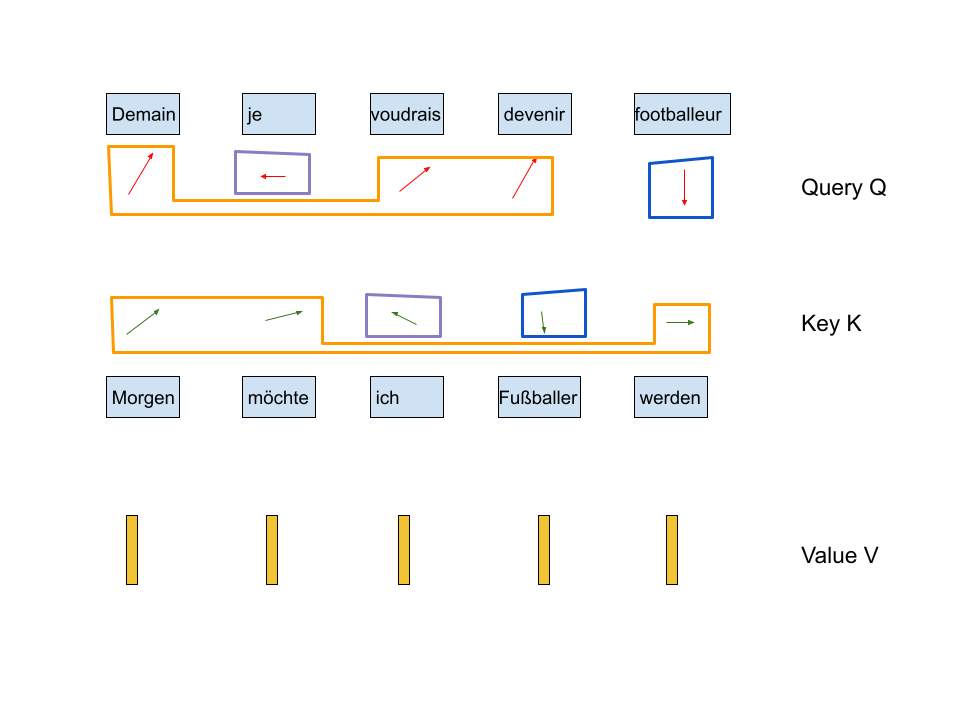

L'idée qu'on peut garder pour autre chose, c'est le localy-sensitive-hashing: une manière très rapide de regrouper des vecteurs par proximité.

In [ ]:
import numpy as np

d=10 #dimension des vecteurs

b=4  #nombre de hash, doit être paire

#on ne prend que  b//2 vecteurs car pour chaque vecteur on va aussi
#considérer son opposé.
R=np.random.normal(size=[d,b//2])

def h(x):
    xR=x@R
    return np.argmax(tf.concat([xR,-xR],axis=0))

Amélioration: on pourrait normaliser les colonnes de `R` pour qu'elle représente des directions (mais ils ne le font pas dans l'article). Car des vecteurs aléatoire de grande dimension ont sont proches en normes: pour $d$ grand:
$$
\sum_{i<d} x_i^2   \sim ???
$$

In [ ]:
for _ in range(20):
    x=np.random.randint(-3,3,size=[d])
    print(f"{x}   \t hash:{h(x)}")

***À vous:*** Décrivez la technique employée avec une phrase simple mais précise.

### Le Linformer

Un modèle des chercheurs de facebook. Je vous laisse apprécier la dernière phrase de l'article:

> We see no immediate negative ethical or
societal impacts of our work beyond what applies to other core building blocks of deep learning.

 L'astuce est  de se donner deux matrices $E$ et $F$ vers une dimension $r<n$ puis on calcule
$$
Q''= attention(Q,FV,EK) = \text{softmax}\left({\underset{nd}{Q}\  (\underset{dn}{K^T}}\underset{nr}{E^T}) \right) (\underset{rn}F \ \underset{nd}V)
$$
Ce qui requiert $dnr+ndr+rnd+nrd$ multiplication. Le terme en $n^2$ n'apparait plus, c'est gagné.

***À vous:*** Vérifiez ce calcul de complexité. Vous devez notamment faire attention au paranthésage pour l'ordre des opérations.

Dans [l'article sur le Linformer](https://arxiv.org/pdf/2006.04768.pdf) ils expliquent que:

* Le calcule de $Q''$ donne des résultats proche de $Q'$. Ils entrainent des modèles avec cette technique, et ça fonctionne.

* La dimension $r$ peut être prise très petite : théoriquement on peut prendre le minimum entre $\log(n)$ et $d\log(d)$. Ainsi la complexité est linéaire en $n$ (d'où le nom "Linformer").

* Les matrices $E$ et $F$ peuvent être prise avec des coefficients aléatoires de loi $\mathcal N(0,{1\over r})$

* Dans les implémentations récentes, ces matrices $E$ et $F$ sont des variables-entrainables.


### Justification mathématique

Pourquoi ça fonctionne ? C'est grâce au théorème suivant dont la preuve (assez simple) se trouve  [ici](https://home.ttic.edu/~gregory/courses/LargeScaleLearning/lectures/jl.pdf)


***Lemme de Johnson-Lindenstrauss*** (variante 'produit scalaire'). Considérons des vecteurs $u,v\in \mathbb R^d$ de norme plus petit que 1. Considérons une matrice aléatoire $F\in \mathbb R^{r \times d}$ avec $ r < d $ dont les éléments sont des v.a i.i.d de loi $N(0,\frac 1 r)$.  
Alors
$$
\mathbf P\big[|u \cdot v - F u \cdot F v| \geq \epsilon\big] \leq 4 e^{-(\epsilon^2 -\epsilon^3)r / 4}
$$




* $u\to Fu$ est une sorte de "projection" aléatoire. Le lemme nous indique qu'une telle projection a de "bonne" chance de préserver le produit scalaire entre 2 vecteurs de la boule unité.

* Souvenez-vous de ce théorème, il peut être très pratique: Si vous travaillez en grande dimension, cette projection aléatoire peut avangeusement remplacer une ACP (qui a un cout de calcul).

* Remarquons par que la dimension de départ $d$ n'intervient pas dans la formule (mis à part qu'elle doit être supèrieur à $r$).



### Vérification informatique

In [ ]:
import tensorflow as tf
tf.random.set_seed(5) #inutile sur colab. Mais sur mon mac, si on ne fixe pas la graine, les tf.random.xxx produisent toujours les mêmes v.a!!!

In [ ]:
d=10000 #dimension des vecteurs initiaux
r=100   #dimension après projection
ε=0.2   #tolérance

In [ ]:
def sca(a,b):
    return tf.reduce_sum(a*b)

In [ ]:
#prenons 2 vecteurs
u=tf.random.normal([d])
v=u+tf.random.normal([d])*0.1
#qu'on normalise pour être dans les hypothèses du lemme
u/=tf.linalg.norm(u)
v/=tf.linalg.norm(v)

In [ ]:
def experience():
    F=tf.random.normal([r,d])
    F/=tf.sqrt(tf.cast(r,tf.float32))
    return tf.abs((sca(u,v)-sca(F@u[:,None],F@v[:,None])))>ε

res=[]
for _ in range(100):
    res.append(experience().numpy())
np.mean(res)

On voit que ça marche: la proba que $u \cdot v$ et $F u \cdot F v$ soient éloignée de plus de $\epsilon$ est petite.

Cependant, on peut se demander si $u \cdot v$ lui-même n'est pas petit:

In [ ]:
def experience2():
    return tf.abs((sca(u,v)))>ε

res=[]
for _ in range(100):
    res.append(experience2().numpy())

#print(res)
np.mean(res)

Ouf, ce n'est pas le cas.

***À vous:*** On a pas prix $u$ et $v$ deux vecteurs indépendants, pourquoi ? Refaites tourner les codes avec $u$ et $v$ indépendant pour comprendre.

On peut regarder la borne de probabilité que donne le lemme:

In [ ]:
p=4*tf.exp(-(ε**2-ε**3)*r/4)
p.numpy()

Elle est largement sous-optimale sur cet exemple (mais ce n'est qu'un exemple).

### Quand les vecteurs bougent

En pratique la matrice de projection sera fixe. Ce sont plutôt les vecteurs qui bougeront. Faisons donc l'expérience ainsi:

In [ ]:
# Fixons la matrice de projetion
F=tf.random.normal([r,d])
F/=tf.sqrt(tf.cast(r,tf.float32))

In [ ]:
def experience_reverse():
    u=tf.random.normal([d])
    v=u+tf.random.normal([d])
    u/=tf.linalg.norm(u)
    v/=tf.linalg.norm(v)
    return tf.abs((sca(u,v)-sca(F@u[:,None],F@v[:,None])))>ε

res=[]
for _ in range(100):
    res.append(experience_reverse().numpy())

np.mean(res)

Cela fonctionne encore.